In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import torchvision
import random
import pandas as pd

from torchray.attribution.grad_cam import grad_cam as tr_gradcam

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import cv2
import matplotlib.pyplot as plt

import os
import clip

In [6]:
def transformer_attention(model, preprocess, file_path, text_list, tokenized_text, device,
                          plot_vis=False, save_vis_path=None, resize=False):
    """
    Credit to: https://github.com/hila-chefer/Transformer-MM-Explainability
    """
    image = preprocess(Image.open(file_path)).unsqueeze(0).to(device)

    logits_per_image, _ = model(image, tokenized_text)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

    attentions = []
    unnormalized_attentions = []
    for idx in range(len(text_list)):
        one_hot = np.zeros((1, logits_per_image.size()[-1]), dtype=np.float32)
        one_hot[0, idx] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.to(device) * logits_per_image)
        model.zero_grad()
        one_hot.backward(retain_graph=True)

        image_attn_blocks = list(
            dict(model.visual.transformer.resblocks.named_children()).values()
        )
        
        num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
        R = torch.eye(num_tokens, num_tokens,
                      dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
        for blk in image_attn_blocks:
            grad = blk.attn_grad
            cam = blk.attn_probs
            cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
            grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
            cam = grad * cam
            cam = cam.clamp(min=0).mean(dim=0)
            R += torch.matmul(cam, R)
        R[0, 0] = 0
        image_relevance = R[0, 1:]

        image_relevance = image_relevance.reshape(1, 1, 7, 7)
        image_relevance = image_relevance.detach().type(torch.float32).cpu()
        if resize:
           image_relevance  = F.interpolate(
               image_relevance, image.shape[2:], mode="bilinear", align_corners=False
            )
        unnormalized_attentions.append(image_relevance)
        image_relevance = normalize(image_relevance)
        attentions.append(image_relevance)

    if plot_vis:
        plot_attention_helper(
            image, attentions, unnormalized_attentions, probs, text_list,
            save_vis_path=save_vis_path, resize=resize
        )

    return {
        'unnormalized_attentions': torch.cat(unnormalized_attentions),
        'attentions': torch.cat(attentions),
        'text_list': text_list,
        'probs': probs
    }

In [7]:
def normalize(sal):
    # sal = tensor of shape 1,1,H,W
    B, C, H, W = sal.shape
    sal = sal.view(B, -1)
    sal_max = sal.max(dim=1, keepdim=True)[0]
    sal_max[torch.where(sal_max == 0)] = 1. # prevent divide by 0
    sal -= sal.min(dim=1, keepdim=True)[0]
    sal /= sal_max
    sal = sal.view(B, C, H, W)
    return sal

def show_cam_on_image(img, attention):
    heatmap = cv2.applyColorMap(np.uint8(255 * attention), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def plot_attention_helper(image, attentions, unnormalized_attentions, probs, text_list,
                          save_vis_path=None, resize=False):
    image_vis = image[0].permute(1, 2, 0).data.cpu().numpy()
    image_vis = (image_vis - image_vis.min()) / (image_vis.max() - image_vis.min())
    attention_vis = []
    for i in range(len(attentions)):
        if not resize:
            sal = F.interpolate(
                unnormalized_attentions[i],
                image.shape[2:], mode="bilinear", align_corners=False
            )
            sal = normalize(sal)[0][0]
        else:
            sal = attentions[i][0][0]
        vis = show_cam_on_image(image_vis, sal.numpy())
        vis = np.uint8(255 * vis)
        attention_vis.append(vis)
    plot(probs, attention_vis, text_list, image_vis, save_path=save_vis_path)


def plot(probs, attention_vis, text_list, image_vis, save_path=None):
    sort = np.argsort(probs)[0][::-1]
    attention_vis = np.array(attention_vis)[sort]
    probs_vis = probs[0][sort]
    text_list_vis = np.array(text_list)[sort]

    fig, ax = plt.subplots(1,1+len(text_list),figsize=(5*(1+len(text_list)),6))
    ax[0].imshow(image_vis)
    ax[0].axis('off')

    for idx in range(len(text_list)):
        ax[idx+1].imshow(attention_vis[idx])
        ax[idx+1].axis('off')
        split = text_list_vis[idx].split(' ')
        if len(split) > 6:
            prompt = ' '.join(split[:6]) + '\n ' + ' '.join(split[6:])
        else:
            prompt = text_list_vis[idx]
        ax[idx+1].set_title('{}\n{:.3f}'.format(prompt, probs_vis[idx], 2),
                           fontsize=14)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
    return

In [12]:
prompts = ['a photo of a waterbird', 'a photo of a waterbody']

image_path = '/scratch/ma7861/datasets/Waterbirds/001.Black_footed_Albatross/Black_Footed_Albatross_0003_796136.jpg'

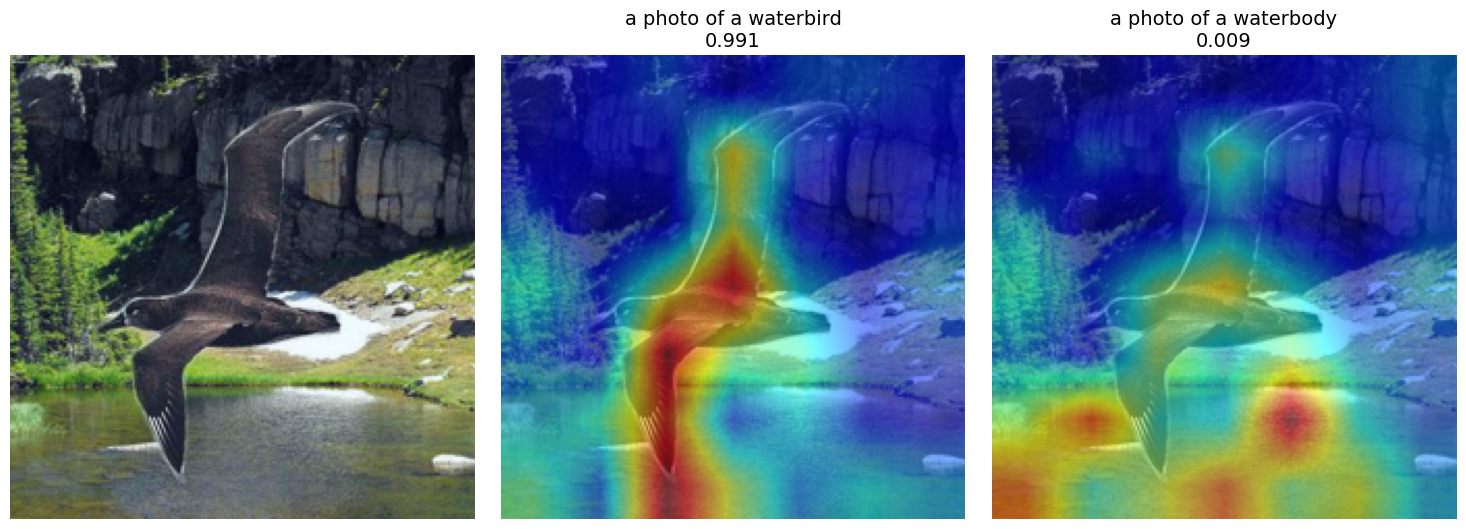

In [13]:
model, preprocess = clip.load('ViT-B/32', device='cpu', jit=False)
tokenized_text = clip.tokenize(list(prompts)).to('cpu')
transform = preprocess

attention = transformer_attention(
                model, transform, image_path,
                text_list=list(prompts),
                tokenized_text=tokenized_text,
                device='cpu',
                plot_vis=True,
                save_vis_path='./',
                resize=False
            )